In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Summary**

The project aims to classify images into "Fake" and "Real" categories using the VGG16 model and transfer learning on the CIFAKE Dataset.
The steps followed in the project can be summarized as follows:

Dataset Preparation: The project utilized a dataset containing images of both real and fake images. The dataset was split into training and testing sets.For convenience I have trained on 4000 images and tested on 400 images. 

Model Architecture: The VGG16 model, pre-trained on the ImageNet dataset, was used as the base model. The last few layers were modified to suit the binary classification task. A fully connected layer with a sigmoid activation function was added as the output layer. 

Model Training: The model was compiled with appropriate loss and optimization functions. Data augmentation techniques such as rescaling, shearing, zooming, and horizontal flipping were applied to the training data to improve model generalization. The model was trained on the augmented training data. 

Model Evaluation: The trained model was evaluated on the testing data. Predictions were made on the test set, and performance metrics such as accuracy, confusion matrix, classification report, and mean average precision (mAP) were calculated to assess the model's performance. 

Visualization: Various visualizations were created to understand the model's predictions better. These included a confusion matrix, loss plot, precision-recall curve, and F1 curve. Additionally, a sample of test images was selected randomly to display the predicted labels and class probabilities. 

The project aimed to develop a model that can accurately classify images as either "Fake" or "Real" based on transfer learning from the VGG16 model. The evaluation metrics and visualizations provided insights into the model's performance and its ability to distinguish between real and fake images.

**References**:

*Krizhevsky, A., & Hinton, G. (2009). Learning multiple layers of features from tiny images.*

*Bird, J.J., Lotfi, A. (2023). CIFAKE: Image Classification and Explainable Identification of AI-Generated Synthetic Images. arXiv preprint arXiv:2303.14126.*

*Real images are from Krizhevsky & Hinton (2009), fake images are from Bird & Lotfi (2023). The Bird & Lotfi study is a preprint currently available on ArXiv and this description will be updated when the paper is published.**

Creating a train and test dataset from the CIFAKE dataset.

In [1]:
import os
import random
import shutil

# Set the paths to your dataset folders
dataset_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train"
real_dir = os.path.join(dataset_dir, "REAL")
fake_dir = os.path.join(dataset_dir, "FAKE")

# Set the paths to the new directories that will contain the selected images
train_dir = "/kaggle/working/train"
real_train_dir = os.path.join(train_dir, "REAL")
fake_train_dir = os.path.join(train_dir, "FAKE")

# Create the new directories if they don't exist
if not os.path.exists(real_train_dir):
    os.makedirs(real_train_dir)
if not os.path.exists(fake_train_dir):
    os.makedirs(fake_train_dir)

# Set the number of images to select from each folder
num_images = 2000

# Randomly select the required number of images from the REAL folder and copy them to the new directory
real_images = os.listdir(real_dir)
selected_real_images = random.sample(real_images, num_images)
for image_name in selected_real_images:
    source_path = os.path.join(real_dir, image_name)
    dest_path = os.path.join(real_train_dir, image_name)
    shutil.copyfile(source_path, dest_path)

# Randomly select the required number of images from the FAKE folder and copy them to the new directory
fake_images = os.listdir(fake_dir)
selected_fake_images = random.sample(fake_images, num_images)
for image_name in selected_fake_images:
    source_path = os.path.join(fake_dir, image_name)
    dest_path = os.path.join(fake_train_dir, image_name)
    shutil.copyfile(source_path, dest_path)
    
# Set the paths to your dataset folders
dataset_dir_test = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test"
real_dir = os.path.join(dataset_dir_test, "REAL")
fake_dir = os.path.join(dataset_dir_test, "FAKE")
# Set the paths to the new directories that will contain the selected images
test_dir = "/kaggle/working/test"
real_test_dir = os.path.join(test_dir, "REAL")
fake_test_dir = os.path.join(test_dir, "FAKE")

# Create the new directories if they don't exist
if not os.path.exists(real_test_dir):
    os.makedirs(real_test_dir)
if not os.path.exists(fake_test_dir):
    os.makedirs(fake_test_dir)

# Set the number of images to select from each folder
num_images = 200

# Randomly select the required number of images from the REAL folder and copy them to the new directory
real_images = os.listdir(real_dir)
selected_real_images = random.sample(real_images, num_images)
for image_name in selected_real_images:
    source_path = os.path.join(real_dir, image_name)
    dest_path = os.path.join(real_test_dir, image_name)
    shutil.copyfile(source_path, dest_path)

# Randomly select the required number of images from the FAKE folder and copy them to the new directory
fake_images = os.listdir(fake_dir)
selected_fake_images = random.sample(fake_images, num_images)
for image_name in selected_fake_images:
    source_path = os.path.join(fake_dir, image_name)
    dest_path = os.path.join(fake_test_dir, image_name)
    shutil.copyfile(source_path, dest_path)


PermissionError: [Errno 13] Permission denied: '/kaggle'

Model creation and Evaluation

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import cv2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt


# Set the paths to the train and test directories
train_dir = os.path.expanduser('~/Downloads/cifake')
test_dir = os.path.expanduser('~/Downloads/cifake')

# Set up the model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

batch_size=512
input_shape = (32, 32, 3)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Perform data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# Load the training data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(32,32),
                                                    batch_size=batch_size, class_mode='binary')

# Repeat the dataset indefinitely
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None])
).repeat()

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None])
).repeat()

# Train the model
history = model.fit(train_dataset, steps_per_epoch=train_generator.n // batch_size, epochs=20)

# Load the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(32,32),
                                                  batch_size=batch_size, class_mode='binary', shuffle=False)

# Make predictions on the test data
predictions = model.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predictions]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels, predictions)
print("\nMean Average Precision (mAP):", mAP)




Found 120000 images belonging to 2 classes.
Epoch 1/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 84s 352ms/step - accuracy: 0.8205 - loss: 0.4850
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 82s 352ms/step - accuracy: 0.8331 - loss: 0.4559
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 83s 353ms/step - accuracy: 0.8330 - loss: 0.4549
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 82s 352ms/step - accuracy: 0.8317 - loss: 0.4557
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 82s 351ms/step - accuracy: 0.8318 - loss: 0.4557
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 82s 350ms/step - accuracy: 0.8334 - loss: 0.4530
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 82s 352ms/step - accuracy: 0.8344 - loss: 0.4510
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 82s 351ms/step - accuracy: 0.8334 - loss: 0.4529
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 82s 351ms/step - accuracy: 0.8337 - loss: 0.4513
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 82s 351ms/step - accuracy: 0.8330 - loss: 0.4522
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 82s 353ms/step - accurac

/home/mahin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


235/235 ━━━━━━━━━━━━━━━━━━━━ 59s 251ms/step

Accuracy: 0.8334666666666667

Confusion Matrix:
[[   20 19980]
 [    4 99996]]

Classification Report:
              precision    recall  f1-score   support

        test       0.83      0.00      0.00     20000
       train       0.83      1.00      0.91    100000

    accuracy                           0.83    120000
   macro avg       0.83      0.50      0.46    120000
weighted avg       0.83      0.83      0.76    120000


Mean Average Precision (mAP): 0.8656245108256997


**Result Visualisation**

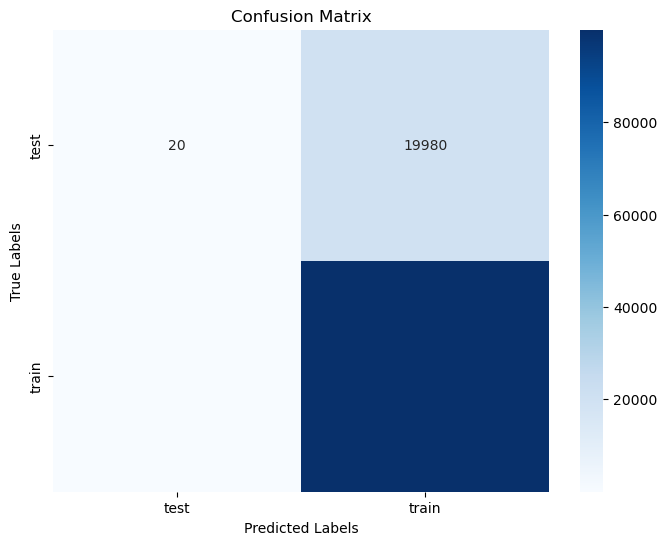

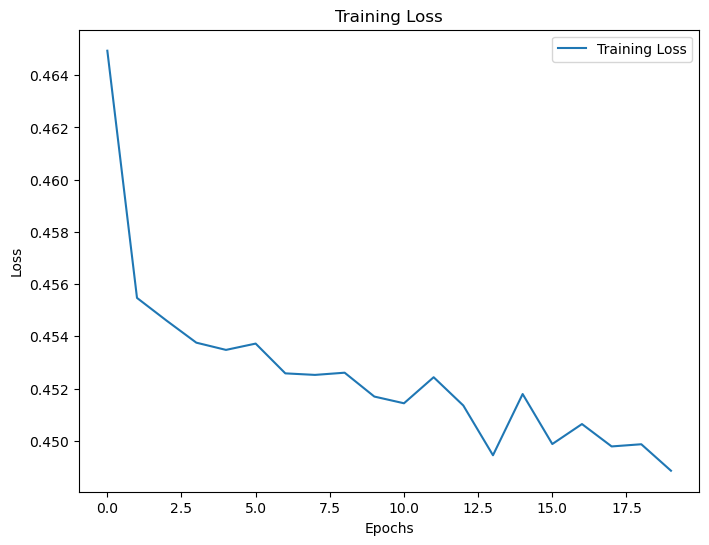

In [13]:
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Loss plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


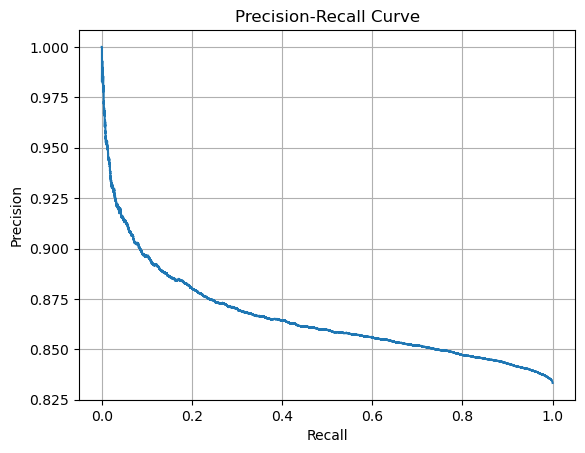

In [14]:
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(test_generator.labels, predictions)

# Plot precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


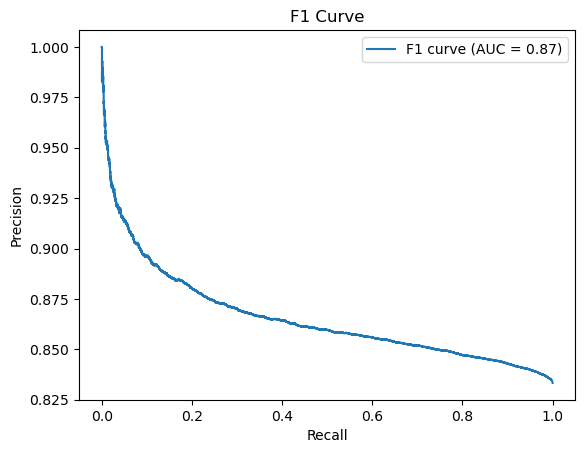

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(test_generator.labels, predictions)

# Calculate F1-score
f1_scores = 2 * (precision * recall) / (precision + recall)

# Calculate area under the curve (AUC)
auc_score = auc(recall, precision)

# Plot the F1 curve
plt.plot(recall, precision, label='F1 curve (AUC = {:.2f})'.format(auc_score))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('F1 Curve')
plt.legend()
plt.show()


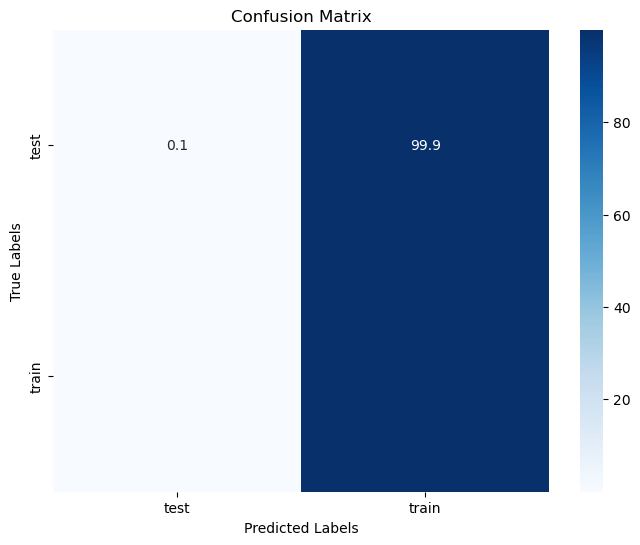

In [16]:


# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
cm_percent = cm / cm.sum(axis=1).reshape(-1, 1) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, cmap='Blues', fmt='.1f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


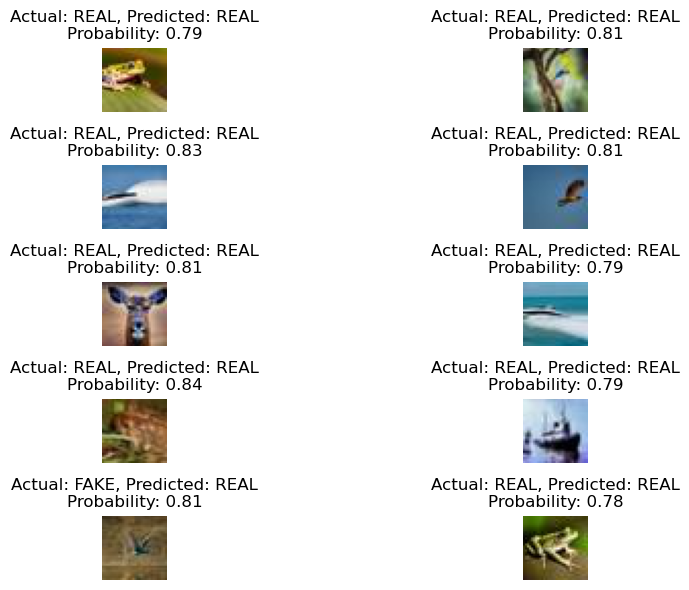

In [17]:


# Select random samples from the test data
sample_indices = np.random.choice(len(test_generator), size=10, replace=False)
sample_images = []
sample_actual_labels = []
sample_predicted_labels = []
sample_probabilities = []

for i in sample_indices:
    image, actual_labels = test_generator[i]
    predicted_label = labels[i]
    probability = predictions[i][0]
    sample_images.append(image[0])  # Access the first image in the batch
    sample_actual_labels.append(actual_labels[0])  # Access the actual label for the first image
    sample_predicted_labels.append(predicted_label)
    sample_probabilities.append(probability)

# Calculate the subplot layout based on the number of sample images
num_images = len(sample_images)
num_rows = int(np.ceil(num_images / 2))
num_cols = min(num_images, 2)

# Plot the sample images with labels and probabilities
plt.figure(figsize=(12, 6))
for i in range(len(sample_images)):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(sample_images[i])
    actual_label = "FAKE" if sample_actual_labels[i] == 0 else "REAL"
    predicted_label = "FAKE" if sample_predicted_labels[i] == 0 else "REAL"
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}\nProbability: {sample_probabilities[i]:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

